In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def x_m(r, m, af, t, z,curve_params):
  # takes in r, the distance between the centre of the glass and the microphone, constant
  # m, a number denoting the fundamental node number labelled counterclockwise, ranging from 1 to 4
  # af, the angular frequency of the rotating glass
  # t, time elapsed since an aritary time zero
  # z, to compute the radius of the the wine glass as a function of height
  # returns the x-axis distance of the sound source m to the microphone
  
  return r-R_cm(z,curve_params)*np.cos(af*t+(m+1)*np.pi/2)   

def R_cf(x, *params):
  a,b,c,d,e,f = params
  return a*x**5+b*x**4+c*x**3+d*x**2+e*x**1+f

def R_cm(x,params):
  a,b,c,d,e,f = params
  return a*x**5+b*x**4+c*x**3+d*x**2+e*x**1+f 

def arclength_int(x,*params):
  a,b,c,d,e = params
  return np.sqrt((5*a*x**4+4*b*x**3+3*c*x**2+2*d*x+e)**2+1)


def chi_squared(model, x_data, y_data, y_error,model_params):
  import scipy.stats
  chisq_min = np.sum(((y_data - model(x_data, model_params))/y_error)**2)
  deg_freedom = len(x_data)-len(model_params)
  P_value = scipy.stats.chi2.sf(chisq_min, deg_freedom)
  return np.sum(((y_data - model(x_data, model_params))/y_error)**2), P_value


def find_arc_lengths():
  import scipy.integrate as integrate
  from scipy.optimize import curve_fit
  ls = []
  sigma_ls = []
  for i in range(1,9):
    points = np.array(pd.read_csv('points{}.csv'.format(i),header=None))
    parameters =  curve_fit(R_cf,points[:,3],points[:,2],p0=[0.0005, 0.0145, 0.1566, 0.9296, 3.164,0.2827])[0]
    ls.append(integrate.quad(arclength_int,0,max(points[:,3]), args = tuple(parameters[:5]))[0])
    sigma_ls.append(integrate.quad(arclength_int,0,max(points[:,3]), args = tuple(parameters)[:5])[1])
    import scipy.stats
    chisq_min = np.sum(((points[:,2] - R_cm(points[:,3],parameters))/0.0335)**2)
    deg_freedom = len(points[:,2])-len(parameters)
    P_value = scipy.stats.chi2.sf(chisq_min, deg_freedom)
  return ls, sigma_ls, chisq_min,P_value

def amplitude_R(z,k,D,L):
  import scipy.integrate as integrate
  r = L-integrate.quad(arclength_int,0,z)[0]
  # integrate_numeric(arclength_int,0,z,10*int(z+1)**2)
  return np.exp((-1)*k*r/(2*D))*np.cos(np.pi*r/(2*L))
def amplitude_T(t,k,D):
  return np.exp((-1)*t*(D**2*np.pi**2+k**2)/(4*D))   
def y_m(m, af, t, z):
  # takes in r, the distance between the centre of the glass and the microphone
  # m, a number denoting the fundamental node number labelled counterclockwise, ranging from 1 to 4
  # af, the angular frequency of the rotating glass
  # t, time elapsed since an aritary time zero
  # R, the radius of the rim of the wine glass
  # returns the y-axis distance of the sound source m to the microphone
  return 5.956*0.01*np.sin(af*t+(m-1)*np.pi/2) 

def dist(x,y):
  return np.sqrt(x**2+y**2)

def new_dist(z,num,h,af,time):
  r = R_cm(z,[9.37319329e-05, -3.87631643e-03,  6.55850004e-02, -5.68807436e-01,
  2.33313630e+00,  3.06441860e-01])
  return np.sqrt((h-z)**2+dist(x_m(15, num, af, time, z), y_m(num, af, time,z))**2)


def f2(array,*params):
  # receives a 1-d array 
  # params[0]=const., parames[1] is coefficient for x,parames[2] is coefficient for x^2 and so on 
  results = []
  for i,param in enumerate(params):
    results.append(array**i*param)
  return np.sum(results,axis=0)

def thickness(z):
  best_fit_params = []
  return f2(z,5,best_fit_params)


def s(v,omega,m,t,freq=694,p=1,k=0,D=1):
  # v is the speed of sound in the room of experiment
  # f is the frequency of the fundamental mode of vibration of the particular wine glass
  s=0
 
  d = dist(x_m(t, m, omega, t, 10.09), y_m(m, omega, t,10.09))
    # freq = fundamental_freq(R(z),thickness(z),z,best_fit_pars)
    # s+= amplitude_R(z=z,k=k,D=D)*amplitude_T(t,k,D)*np.cos(2*np.pi*n_dist*freq/v+m*np.pi+2*np.pi*freq*t)/(n_dist*0.01)**p
  s+= np.cos(2*np.pi*d*freq/v+m*np.pi+2*np.pi*freq*t)/d
  return s


def signal_and_plot(frequency_oi,time_tot,af=3):
  # takes in the highest frequency of interest, determine the minimum sampling rate required and create the times array accordingly
  # frequency_oi = fundamental_freq(R(z),thickness(z),z,best_fit_pars)
  sampling_rate = frequency_oi*2
  # generate sound amplitudes for 5 seconds at the Nyquist sampling rate
  times = np.linspace(0,time_tot,int(sampling_rate)*(time_tot)) 
  signals = np.zeros_like(times) 
  for u,time in enumerate(times):
    signal = 0
    for i in range(1,5):
      #s(v,af,m,t,,freq=694,p=1,k=0,D=1)
      signal+=s(v=343,m=i,t=time,omega=af)
    signals[u] = signal
  plt.plot(times,signals)
  plt.xlabel('time (s)')
  plt.ylabel('amplitude')
  plt.title('Amplitude vs. Time (fundamental mode+decay)')


In [35]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
gin_partially_filled= np.array(pd.read_csv('partially_filled_gin_7(vol,f,h).csv',header=None))
def lin_mod(x,*params):
  return params[0]*x+params[1]
gin_f0 = 552
def find_freq_err(f,t):
  return abs(t/(t+0.02)-1)*f
def lin_mod_cs(x,params):
  return params[0]*x+params[1]


-137.54043786925862 4.032565151576818
5.517721647233014 0.03978623855564682
(8.057209397671254, 0.01779914780710322)
H* : 0.08819413980518147
H* uncertainty : 0.059493115285649864


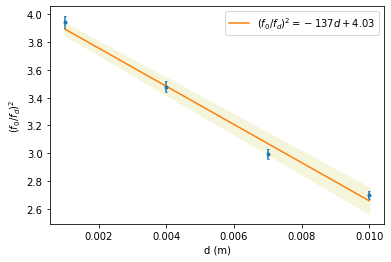

In [36]:
last_few_f0 = gin_partially_filled[-4:,1]
last_few_h = gin_partially_filled[-4:,2]*0.01 
y = (gin_f0/np.float32(last_few_f0))**2
few_f0_errs = find_freq_err(last_few_f0,5)
y_err = [np.sqrt((find_freq_err(gin_f0,5)*2*gin_f0/f**2)**2+(2*gin_f0**2/f**3*err)**2) for f,err in zip(last_few_f0,few_f0_errs)]
p_excel_h = np.array([-0.7044, 2.8595])*0.01
p_excel_l = np.array([-0.7044, 5.7695])*0.01
gin_height = 8.8*0.01
gin_arc_l = 11.71*0.01
d_h = gin_height-last_few_h
d_l = gin_arc_l-last_few_h
# print(d_h,d_l)
popt_h, pcov_h = curve_fit(lin_mod, d_h, y, sigma = y_err,absolute_sigma = True ,p0 = p_excel_h)
# print(popt_h)
popt_sigma = abs(np.array(np.sqrt(pcov_h[0,0]),np.sqrt(pcov_h[1,1])))
m,b = popt_h
sigma_m, sigma_b = abs(np.sqrt(pcov_h[0,0])),abs(np.sqrt(pcov_h[1,1]))
# print(np.sqrt(pcov_h[0,0]),np.sqrt(pcov_h[1,1]))
plt.errorbar(d_h,y,yerr=y_err,fmt='.',capsize=1)
plt.plot(d_h,lin_mod_cs(d_h,popt_h), label = "$(f_0/f_d)^2 = -137d+ 4.03$")
plt.fill_between(d_h, lin_mod_cs(d_h,(m-sigma_m,b-sigma_b)), lin_mod_cs(d_h,(m+sigma_m,b+sigma_b)),color='beige')
plt.xlabel("d (m)")
plt.ylabel("$(f_0/f_d)^2$")
# popt_l, pcov_l = curve_fit(lin_mod,d_l, y, sigma = y_err, absolute_sigma = True ,p0 = p_excel_l)
plt.legend()
print(m,b)
print(sigma_m,sigma_b)
# print(np.sqrt(pcov_l[0,0]),np.sqrt(pcov_l[1,1]))
# print(chi_squared(lin_mod_cs, d_l, y, y_err,popt_l))
print(chi_squared(lin_mod_cs, d_h, y, y_err,popt_h))
print("H* :",(-4)*(popt_h[1]-1)/popt_h[0])
print("H* uncertainty :",np.sqrt((4/m*sigma_b)**2+np.sqrt(4*(b-1)/m**2*sigma_m)**2))

In [37]:
def partially_filled_model(d,c, eff_h):
  return 1+c*(1-d/eff_h)**4

def pfm_cs(d,params):
  c = params[0]
  eff_h = params[1]
  return 1+c*(1-d/eff_h)**4

In [61]:
def exp_mod(x,c,p):
    return c*np.exp(p*x)

def exp_cs(x,params):
  return params[0]*np.exp(params[1]*x)

[74.95714265 -3.87912084] [5.33002668 1.3177965 ]
(17.383241758241752, 0.09703945856050131)
-3.899824634163888e-09 1.1563617266848956


[Text(0, -2.0, ''), Text(0, 0.0, ''), Text(0, 2.0, ''), Text(0, 4.0, '')]

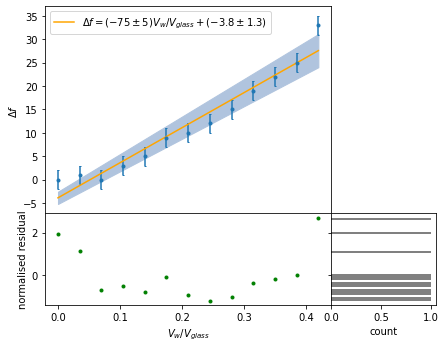

In [100]:
gin_filled_f0 = gin_partially_filled[:,1]
hs = gin_partially_filled[:,2]*0.01 
y = (gin_f0/np.float32(gin_filled_f0))**2
gf_f0_errs = find_freq_err(gin_filled_f0,5)
y_err = [np.sqrt((find_freq_err(gin_f0,5)*2*gin_f0/f**2)**2+(2*gin_f0**2/f**3*err)**2) for f,err in zip(gin_filled_f0,gf_f0_errs)]
gin_height = 8.8*0.01
gin_arc_l = 11.71*0.01
data = np.array(pd.read_csv('partially_filled_gin_7(vol,f,h).csv',header=None))
dv = data[:13,3]
df = 552- gin_filled_f0[:13]
df_err = 2.
popt,pcov = curve_fit(lin_mod,dv,df,p0=(270,-50))
perr = np.array([np.sqrt(pcov[0,0]),np.sqrt(pcov[1,1])])
lin_mod_exp = lin_mod_cs(dv,popt)
norm_res = (df - lin_mod_exp)/df_err
print(popt,perr)
# print(norm_res)
print(chi_squared(lin_mod_cs, dv, df, df_err, popt))
print(np.mean(norm_res),np.std(norm_res))
# print(popt,perr)
d_h = gin_height-hs
d_l = gin_arc_l-hs

# popt_h, pcov_h = curve_fit(partially_filled_model , d_h, y, sigma = y_err,absolute_sigma = True ,p0 = (8,0.2))
# c, eff_h = popt_h
# c_err, eff_h_err = np.sqrt(pcov_h[0,0]),np.sqrt(pcov_h[1,1])
# # print(popt_h)
# # print(np.sqrt(pcov_h[0,0]),np.sqrt(pcov_h[1,1]))
# y_min  = pfm_cs(d_h,[c+c_err,eff_h+eff_h_err])
# y_max = pfm_cs(d_h,[c-c_err,eff_h-eff_h_err])
# x = (1-d_h/eff_h)**4
# y_expected = pfm_cs(d_h,popt_h)
# norm_residuals = (y-y_expected)/y_err
# print(np.mean(norm_residuals),np.std(norm_residuals))
# print(chi_squared(pfm_cs, d_h, y, y_err,popt_h))
fig = plt.figure(figsize=(7.,5.5))
gs = fig.add_gridspec(2, 2,  width_ratios=(2.75,1), height_ratios=(2.25,1),
wspace=0., hspace=0.)
ax1 = fig.add_subplot(gs[0])
ax1.errorbar(dv,df,yerr = df_err,fmt='.',capsize=1)
ax1.plot(dv,lin_mod_exp,color='orange',label="$\Delta f = (-75 \pm 5)  V_w /V_{glass} + (-3.8 \pm 1.3) $")
ax1.legend()
ax1.set_ylabel('$\Delta f$')
ax1.fill_between(dv, lin_mod_cs(dv,popt-perr), lin_mod_cs(dv,popt+perr),color='lightsteelblue')
# print(lin_mod_cs(dv,popt-perr))
ax3 = fig.add_subplot(gs[2],sharex=ax1)
ax3.scatter(dv,norm_res,marker='.',color='green')
ax3.set_xlabel('$V_w/V_{glass}$')
ax3.set_ylabel('normalised residual')
ax4 = fig.add_subplot(gs[3])
ax4.hist(norm_res, bins=40, orientation="horizontal",color="grey")
# ax4.set_xticklabels(['0',' 2'])
ax4.set_xlabel('count')
ax4.set_yticklabels([])

# print("H* :",(-4)*(popt_h[1]-1)/popt_h[0])
# print("H* uncertainty :",np.sqrt((4/m*sigma_b)**2+np.sqrt(4*(b-1)/m**2*sigma_m)**2))

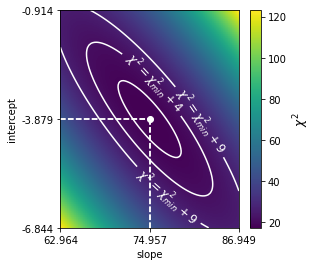

In [117]:
a_range = 2.25 * perr[0]
b_range = 2.25 * perr[1]

n_points = 100          

# Generate grid and data
a_axis = np.linspace(popt[0]-a_range, popt[0]+a_range, num=n_points)
a_label = [popt[0]-a_range, popt[0],popt[0]+a_range]
a_label = [int(la*1000)/1000. for la in a_label ]

b_axis = np.linspace(popt[1]-b_range, popt[1]+b_range, num=n_points)
b_label = [popt[1]-b_range, popt[1],popt[1]+b_range]
b_label = [int(lb*1000)/1000. for lb in b_label ]
plot_data = np.zeros((n_points, n_points))

for i, b_val in enumerate(b_axis): 
    for j, a_val in enumerate(a_axis): # Nested loops for clarity...
        plot_data[i][j] = chi_squared(lin_mod_cs, dv, df, df_err,[a_val,b_val])[0]


plt.figure(figsize=(4,4))
ax = plt.gca()
im = plt.imshow(plot_data, extent=(a_axis[0], a_axis[-1], 
                                   b_axis[0], b_axis[-1]), 
                origin='lower', aspect='auto')

plt.xlim(popt[0]-a_range, popt[0]+a_range) # axis ranges
plt.ylim(popt[1]-b_range, popt[1]+b_range)
ax.set_xticks(ticks = a_label, labels= a_label)
ax.set_yticks(ticks = b_label, labels = b_label)
plt.xlabel('slope') # Axis labels
plt.ylabel('intercept')

cbar=plt.colorbar(im, orientation='vertical') # # Colorbar and label
cbar.set_label('$\chi^2$', fontsize=12)

plt.plot(popt[0], popt[1], 'wo') # Add in best fit point and dashed lines
plt.plot((popt[0], popt[0]), (b_axis[0], popt[1]), 
         linestyle='--', color='w')
plt.plot((a_axis[0], popt[0]), (popt[1], popt[1]), 
         linestyle='--', color='w')

# X, Y = np.meshgrid(a_axis, b_axis, indexing='xy')
contour_data = plot_data - chi_squared(lin_mod_cs,dv,df,df_err,popt)[0]

levels = [1, 4, 9] # Contour levels to plot:
# delta chi-squared of 1, 4 & 9 correspond to 1, 2 & 3 standard deviations

contour_plot = plt.contour(a_axis, b_axis, contour_data, 
                           levels=levels, colors='w', origin = 'lower')
plt.clabel(contour_plot, levels, fontsize=12, inline=1, 
           fmt=r'$\chi^2 = \chi^2_{min}+%1.0f$') 

import matplotlib.ticker as ticker # Allows you to modify the tick markers to 
xtick_spacing = 0.5                # assess the errors from the chi-squared 
ytick_spacing = 0.02               # contour plots.
 
# ax.xaxis.set_major_locator(ticker.MultipleLocator(xtick_spacing))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(ytick_spacing))
ax.set_xticks([a_axis[0],popt[0],a_axis[-1]],a_label)
ax.set_yticks([b_axis[0],popt[1],b_axis[-1]],b_label)
# ax.set_xticks(ticks =a_axis, labels = a_label)
# ax.set_yticks(ticks= b_axis, labels = b_label)
# plt.plot(popt[0], popt[1], 'ro') # Add in best fit point and dashed lines to axes
plt.plot((popt[0], popt[0]), (b_axis[0], popt[1]), linestyle='--', color='w')
plt.plot((a_axis[0], popt[0]), (popt[1], popt[1]), linestyle='--', color='w')
plt.show()

# contours = contour_plot.collections[0].get_paths()    
# # Get the set of points constituting the one confidence-interval contour
# onesigma_contour = contours[0].vertices       

# # Get the extrema along the two axes - max and min values
# # These should be symmetric about the solution...
# maxs = np.amax(onesigma_contour, axis=0)   
# mins = np.amin(onesigma_contour, axis=0)   
# errs_graphical = (maxs-mins)/2  # Calculate one standard error in the parameters

# a_error, b_error = errs_graphical

In [6]:

# filled_heights = np.array(pd.read_csv('Book1.csv',header=None))
# corresponding_radius = R(filled_heights)
# d = pd.DataFrame(corresponding_radius)
# d.to_csv('radii.csv')

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot4d_data_model(data, model_c):
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(121,projection="3d")
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    x, y, z = data[0],data[1],data[2]
    ax.scatter(x, y, z,c=data[-1], edgecolor="k", alpha=1, marker="o", cmap='YlGnBu_r',vmin =data[-1].min() ,vmax = data[-1].max())
   
    # Add colorbar
    # Normalizer
    cmap='YlGnBu_r'
    norm_data = mpl.colors.Normalize(vmin =data[-1].min() ,vmax =data[-1].max())
    # creating ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_data)
    sm.set_array([])
    cbar_data = plt.colorbar(sm,ax = ax,shrink=0.4,fraction=0.1)
    cbar_data.set_label('measured frequency (Hz)', rotation=90,loc = 'top')
    ax.view_init(elev=45, azim=210)
    ax.dist=11
    ax.set_xlabel('rim radius (cm)')
    ax.set_ylabel('rim thickness (cm)')
    ax.set_zlabel('body height (cm)')
  
    ax_1 = plt.subplot(122,projection='3d')
    ax_1.xaxis.pane.fill = False
    ax_1.yaxis.pane.fill = False
    ax_1.zaxis.pane.fill = False
    ax_1.scatter(x, y, z, c=model_c, edgecolor="k", alpha=1, marker="o", cmap='YlGnBu_r',vmin=model_c.min(),vmax=model_c.max())
    ax_1.set_xlabel('rim radius (cm)')
    ax_1.set_ylabel('rim thickness (cm)')
    ax_1.set_zlabel('body height (cm)')
    norm_model = mpl.colors.Normalize(vmin =model_c.min() ,vmax =model_c.max())
    # creating ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_model)
    sm.set_array([])
    cbar_model = plt.colorbar(sm,ax = ax_1,shrink=0.4,fraction=0.1)
    cbar_model.set_label('model output frequency (Hz)', rotation=90,loc = 'top')
    ax_1.view_init(elev=45, azim=210)
    ax_1.dist=11

    # plt.savefig("test_scatter_4d.png", dpi=250)
    # plt.close(fig)


In [8]:
# curve_fit for multivariable functions: x=[[,,,,],[,,,,],[,,,,]] : 3 independent variables:rad,thick,body_height (rim radius,rim thickness and glass body height ), 5 datapoints
glass_measurements = np.array(pd.read_csv('glass measurements copy.csv',header=None))
# Glass measurements column headings:
# F0, rim thickness, rt sigma, rim radius, rr sigma, body height, bh sigma, total_volume
ls,ls_sigma,chi_m,p = find_arc_lengths()
ls = np.array(ls)
print(ls)
ls_sigma = np.array(ls_sigma)
print(ls_sigma)

[12.73860223  9.92054624 11.16547693 12.87110298 11.05914525 14.18921195
 11.70695948 11.24322416]
[1.81548465e-08 4.19916377e-09 3.09164424e-09 5.06202375e-09
 1.05115845e-09 1.02965827e-08 8.05015678e-11 1.29394806e-07]


[-7.78766609e-02 -5.08572006e+00  1.00870947e+03]
[6.34613978e-02 1.43084689e+01 3.52438240e+02]
tolerance: [-794.93449403 -592.90568789 -716.69189405 -620.95713105 -889.00397646
 -792.83176915 -636.08127701 -647.44641364]
(33779.446451025746, 0.0)
[580.36264351 852.03089784 738.60252489 814.14563387 717.99826819
 543.06983591 786.11726464 786.97803003]
[580.36264351 852.03089784 738.60252489 814.14563387 717.99826819
 543.06983591 786.11724422 786.97803003]


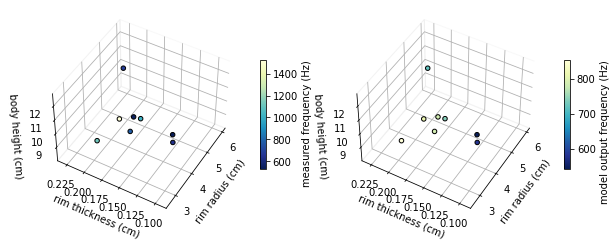

In [89]:
# model from energy analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
data = np.array(pd.read_csv('glasses.csv',header=None))
# f0, rim thickness	rt s.e.	rim radius	rr s.e.	body height	bh s.e., volume
f0 = np.array([ 633.8, 1117.4 , 1011.01, 1522.2 , 677.4 , 529.0,  550.6,  778.4])
f0_err = data[:,0]*(5/5.02-1)
data = [data[:,3],data[:,1],data[:,-3],data[:,-1],f0]

def model_cf(data,*param):
  a = data[0]*0.01
  r = data[1]*0.01
  l = data[2]*0.01
  v = data[3]*0.000001
  ratio = r/l
  a_r2 = a/r**2
  return (2*np.pi)**(-1)*param[0]*a_r2*(1+4./3*(ratio)**4)**0.5 +param[1]*np.pi*a**2/v+param[2]
  
def model_cs(data,param):
  a = data[0]*0.01
  r = data[1]*0.01
  l = data[2]*0.01
  v = data[3]*0.000001
  ratio = r/l
  a_r2 = a/r**2
  return (2*np.pi)**(-1)*param[0]*a_r2*(1+4./3*(ratio)**4)**0.5 +param[1]*np.pi*a**2/v+param[2]

popt,pcov = curve_fit(model_cf,data,f0,sigma=f0_err,p0=(1.,1,-1))
sigma = np.array([np.sqrt(pcov[0,0]),np.sqrt(pcov[1,1]),np.sqrt(pcov[2,2])])
print(popt)  
print(sigma)
model_output = model_cs(data,popt) 
tolerance = (model_cs(data,popt-sigma)-model_cs(data,popt))
print("tolerance:",tolerance)
print(chi_squared(model_cs, data, f0, f0_err,popt))
plot4d_data_model(data,model_cs(data,popt))
print((model_cs(data,popt)))
data[2][-2] = 7.5
print((model_cs(data,popt)))
plt.savefig('eq9.png')

In [10]:

data = np.array(pd.read_csv('spectrum of singing wine glass 1.txt', sep="\t", header = None))[0:506]
background_data = np.array(pd.read_csv('spectrum of background noise.txt', sep="\t", header = None))
amp_dat = 10**(data[:,1]/20)
amp_back = 10**(background_data[:,1]/20)
cleaned_data = 20*np.log10(np.array([amp_dat[i] -np.average(amp_back[62*i:62*(i+1)]) for i in range(len(amp_dat))]))

print(data[:,0][np.argmax(cleaned_data)])

689.0625


In [162]:
plt.plot(data[:,0],data[:,1],label='unfiltered amplitude')
plt.plot(background_data[:,0], background_data[:,1],label='background amplitude')
plt.scatter(data[:,0],cleaned_data,label='cleaned amplitudes', alpha=0.5,marker = '.',color='g')
plt.xlabel('frequency (Hz)')
plt.ylabel('amplitude (dB)')
plt.legend()

ValueError: s must be a scalar, or float array-like with the same size as x and y

In [ ]:
def FFT(signals, times, plot=True):
    '''
    Determine and plot (positive frequency) FFT, and from these 
    determine the phase-shift between 2 datasets using 
    cross-correlation from Fast Fourier Transforms.
    signals and times are arrays of the same shape, providing a
    timestamp for each signal. 
    Returns arrays of frequencies and amplitudes of (non-zero frequency) 
    fundamental tone, and the phase shift between the signals.
    '''   
    from scipy.fftpack import fft, ifft
    from scipy.signal import argrelmax, argrelmin
    ffts = fft(signals) 
    yf = 2.0/len(signals) * np.abs(ffts[:len(signals)//2])
    xf = np.linspace(0.0, 
                        len(times)/(2.0*(times[-1]-times[0])), 
                        len(times)//2)
    freq = xf[np.argmax(yf)]
    amp = np.max(yf) 
    if plot:
        plt.figure(figsize=(10,4))
        plt.plot(xf[0:len(xf)//10], yf[0:len(xf)//10])
        plt.xlabel('Frequency (Hz)'); plt.ylabel('Amplitude')
        plt.title('Frequency components of recorded data')
 
    return freq, amp

(633.8057476580425, 2380.589604809856)
(1117.410127339466, 3270.9131413039236)
(1011.0091630035799, 3442.762068034175)
(1522.213796166221, 2203.2390894561895)
(677.4061448307767, 732.0878172211515)
(529.0047986647194, 739.31686645244)
(550.6049931532316, 2232.3111481138367)
(778.4070589728941, 3255.4743889696556)


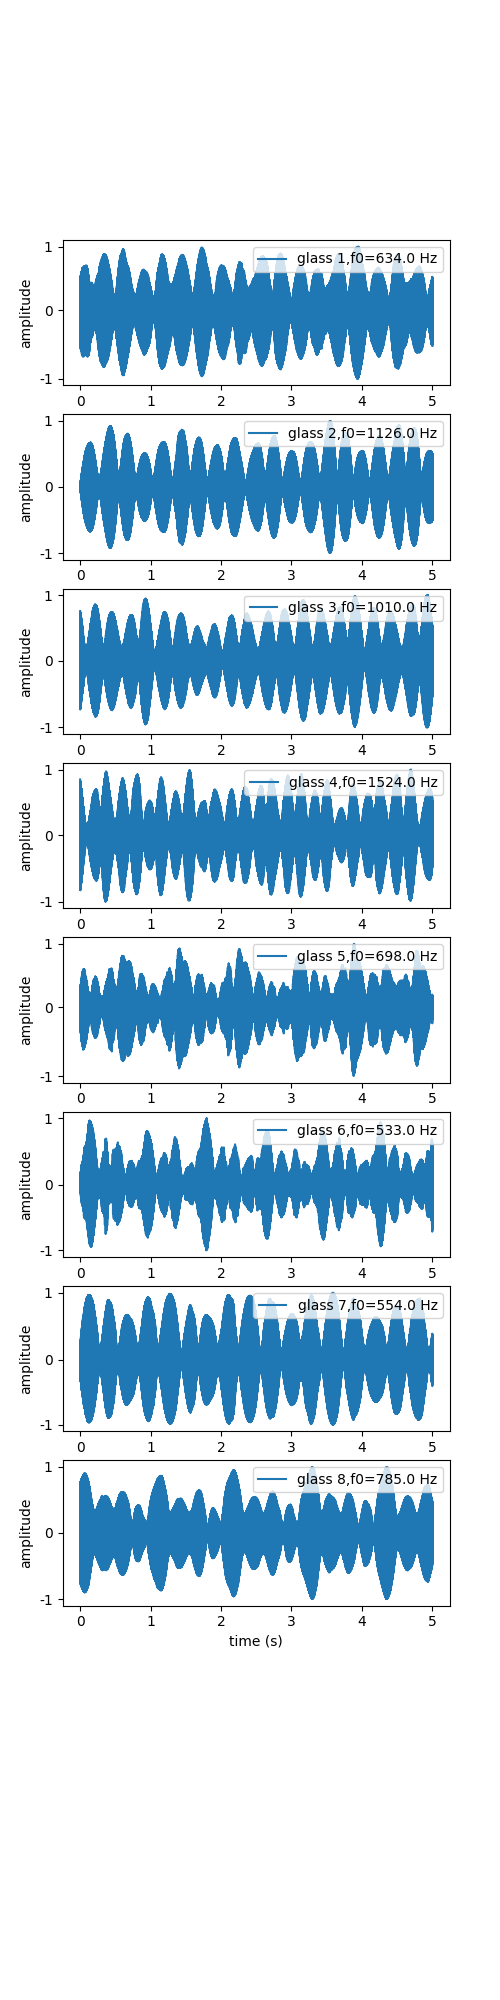

In [ ]:
from scipy.io import wavfile
fig = plt.figure(figsize=(5,20))

for i in range(1,9):
  samplerate, audio_data = wavfile.read('Glass {} Ring 5 secs.wav'.format(i))
  ax = plt.subplot(910+i)
  ax.plot(np.linspace(0,5,len(audio_data[:,1])),audio_data[:,1],label="glass {},f0={} Hz".format(i,f0[i-1]))
  ax.set_xlabel('time (s)')
  ax.set_ylabel('amplitude')
  ax.set_yticks([audio_data[:,1].min(),0,audio_data[:,1].max()],labels=[-1,0,1])
  ax.legend(loc="upper right")
  print(FFT(audio_data[:,1],np.linspace(0,5,len(audio_data[:,1])),plot=False))


(778.4070589728941, 3255.4743889696556)

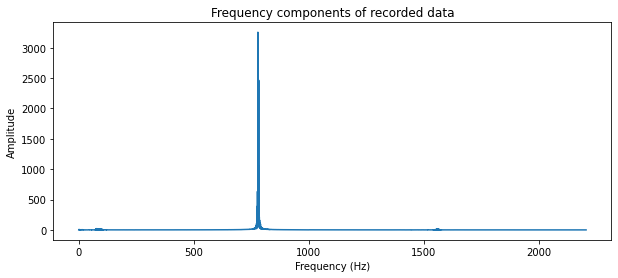